# Data sources
1. [phamdinhkhanh/vnquant](https://github.com/phamdinhkhanh/vnquant)
2. [nguyenngocphung/stock-prices-vn30-indexvietnam](https://www.kaggle.com/datasets/nguyenngocphung/stock-prices-vn30-indexvietnam)

*References:*

* [Scikit-learn (2020). GridSearchCV.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [Scikit-learn (2020). RandomizedSearchCV.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

# Environment Setup

In [ ]:
# Colab-only

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Colab-only
# Change directory to current project

PROJECT_ABSOLUTE_DIR = '/content/drive/MyDrive/Colab Notebooks/Stock-Price-Foreseeing'
current_folder = %pwd
if current_folder != PROJECT_ABSOLUTE_DIR:
  %cd {PROJECT_ABSOLUTE_DIR}
!ls

/content/drive/MyDrive/Colab Notebooks/Stock-Price-Foreseeing
data


In [ ]:
# Colab-only
# Should run once only if package 'vnquant' is not installed

!git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python3 setup.py install
%cd ..
!rm -rf vnquant
!ls
!pip3 freeze | grep vnquant

In [ ]:
!pip3 install pandas_ta

In [2]:
import os
import pandas as pd
import pandas_ta
import numpy
import vnquant 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

print(
    '===== Package version =====',
    f'Pandas: {pd.__version__}',
    f'Pandas_ta: {pandas_ta.__version__}',
    f'Numpy: {numpy.__version__}',
    f'Vnquant: {vnquant.__version__}',
    f'Matplotlib: {matplotlib.__version__}',
    f'Seaborn: {sns.__version__}',
    f'Scikit-learn: {sklearn.__version__}',
    sep='\n'
)

===== Package version =====
Pandas: 2.0.3
Pandas_ta: 0.3.14b0
Numpy: 1.25.1
Vnquant: 0.1.1
Matplotlib: 3.7.2
Seaborn: 0.12.2
Scikit-learn: 1.3.0


# Global

In [3]:
DATA_DIR = 'data'
DATA_RAW_DIR = 'data/raw'
PROCESSED_DATA_DIR = 'data/processed'
STOCK_INDEX_PARAM = 'FPT'

In [4]:
def print_dataframe_details(df):
  print(df)
  df.info()
  print(df.describe())

# Data Preparation

**Read and standardize dataframes:** because data are collected from the two different sources (kaggle & vnquant), they need to be reformatted to the same form.

In [5]:
kaggle_df = pd.read_csv(f'{DATA_RAW_DIR}/kaggle/{STOCK_INDEX_PARAM}.csv')
kaggle_df.drop('<Ticker>', axis=1, inplace=True)
kaggle_df.columns = kaggle_df.columns.str.replace('[<>]', '', regex=True) 
kaggle_df.rename(columns={"DTYYYYMMDD": "Date"}, inplace=True, errors="raise")
kaggle_df['Date'] = pd.to_datetime(kaggle_df['Date'].astype(str), format='%Y%m%d')
kaggle_df = kaggle_df[['Date', 'Open', 'High', 'Low', 'Close']]
kaggle_df.sort_values(by=['Date'], inplace=True)
kaggle_df = kaggle_df.reset_index(drop=True)
print_dataframe_details(kaggle_df)

           Date     Open     High      Low    Close
0    2006-12-13  19.4343  19.4343  19.4343  19.4343
1    2006-12-14  20.4060  20.4060  20.4060  20.4060
2    2006-12-15  21.4263  21.4263  21.4263  21.4263
3    2006-12-18  22.4952  22.4952  22.4952  22.4952
4    2006-12-19  23.6127  23.6127  23.6127  23.6127
...         ...      ...      ...      ...      ...
3613 2021-06-21  85.6000  86.3000  83.2000  85.6000
3614 2021-06-22  86.1000  86.6000  85.4000  85.4000
3615 2021-06-23  85.3000  85.6000  84.1000  84.9000
3616 2021-06-24  84.3000  84.9000  83.9000  84.7000
3617 2021-06-25  84.7000  85.4000  84.2000  85.2000

[3618 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3618 non-null   datetime64[ns]
 1   Open    3618 non-null   float64       
 2   High    3618 non-null   float64       
 3   Low     3618 non-nul

In [6]:
def vnquant_load_raw_data(source, force_reload=False):
  VNQUANT_DATA_FOLDER = f'{DATA_RAW_DIR}/vnquant'
  STOCK_INDEX_DATA_CSV = f'{VNQUANT_DATA_FOLDER}/{STOCK_INDEX_PARAM}.csv'

  if os.path.exists(STOCK_INDEX_DATA_CSV) and not force_reload:
    return pd.read_csv(STOCK_INDEX_DATA_CSV)

  data_loader = vnquant.data.DataLoader(
      symbols=f'{STOCK_INDEX_PARAM}',
      start="2021-06-26",
      end="2022-12-31",
      minimal=True,
      data_source=source
  )
  os.makedirs(VNQUANT_DATA_FOLDER, exist_ok=True)
  data_loader.download().to_csv(STOCK_INDEX_DATA_CSV)

  return pd.read_csv(STOCK_INDEX_DATA_CSV)

In [7]:
vnquant_df = vnquant_load_raw_data('vnd', False)
vnquant_df.drop(index=[0, 1], columns=['avg', 'volume'], inplace=True)
vnquant_df.rename(mapper=str.capitalize, axis='columns', inplace=True, errors="raise")
vnquant_df.rename(columns = {'Attributes':'Date'}, inplace=True, errors="raise")
vnquant_df = vnquant_df[['Date', 'Open', 'High', 'Low', 'Close']]
vnquant_df['Date'] = pd.to_datetime(vnquant_df['Date'])
vnquant_df.iloc[:, 1:] = vnquant_df.iloc[:, 1:].astype(float)
vnquant_df.sort_values(by=['Date'], inplace=True)
vnquant_df = vnquant_df.reset_index(drop=True)
print_dataframe_details(vnquant_df)

          Date  Open  High   Low Close
0   2021-06-28  86.1  86.1  85.4  85.7
1   2021-06-29  86.6  89.0  86.3  88.6
2   2021-06-30  89.0  89.1  88.0  88.0
3   2021-07-01  88.1  88.9  88.0  88.9
4   2021-07-02  89.3  92.5  88.9  91.9
..         ...   ...   ...   ...   ...
377 2022-12-26  77.7  78.1  76.4  76.4
378 2022-12-27  76.4  77.5  76.0  76.5
379 2022-12-28  77.0  77.0  76.0  76.7
380 2022-12-29  76.5  77.0  76.2  76.2
381 2022-12-30  76.2  76.9  76.0  76.9

[382 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    382 non-null    datetime64[ns]
 1   Open    382 non-null    object        
 2   High    382 non-null    object        
 3   Low     382 non-null    object        
 4   Close   382 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 15.1+ KB
                                Date

We will use dataset Kaggle as training set and Vnquant as test set.

In [8]:
training_set, test_set = kaggle_df.set_index('Date'), vnquant_df.set_index('Date')
print(training_set)
print(training_set.dtypes)
print(test_set)
print(test_set.dtypes)

               Open     High      Low    Close
Date                                          
2006-12-13  19.4343  19.4343  19.4343  19.4343
2006-12-14  20.4060  20.4060  20.4060  20.4060
2006-12-15  21.4263  21.4263  21.4263  21.4263
2006-12-18  22.4952  22.4952  22.4952  22.4952
2006-12-19  23.6127  23.6127  23.6127  23.6127
...             ...      ...      ...      ...
2021-06-21  85.6000  86.3000  83.2000  85.6000
2021-06-22  86.1000  86.6000  85.4000  85.4000
2021-06-23  85.3000  85.6000  84.1000  84.9000
2021-06-24  84.3000  84.9000  83.9000  84.7000
2021-06-25  84.7000  85.4000  84.2000  85.2000

[3618 rows x 4 columns]
Open     float64
High     float64
Low      float64
Close    float64
dtype: object
            Open  High   Low Close
Date                              
2021-06-28  86.1  86.1  85.4  85.7
2021-06-29  86.6  89.0  86.3  88.6
2021-06-30  89.0  89.1  88.0  88.0
2021-07-01  88.1  88.9  88.0  88.9
2021-07-02  89.3  92.5  88.9  91.9
...          ...   ...   ...   ...
20

# Data Analysis And Preprocessing

In [9]:
zero_value_index_as_str = training_set.loc[training_set['Open'] == 0].index.strftime('%Y-%m-%d').values[0]
training_set.loc[zero_value_index_as_str]['Open'] = training_set[training_set['Open'].index < zero_value_index_as_str]['Open'].mean()
training_set.describe()

22.291139999999995


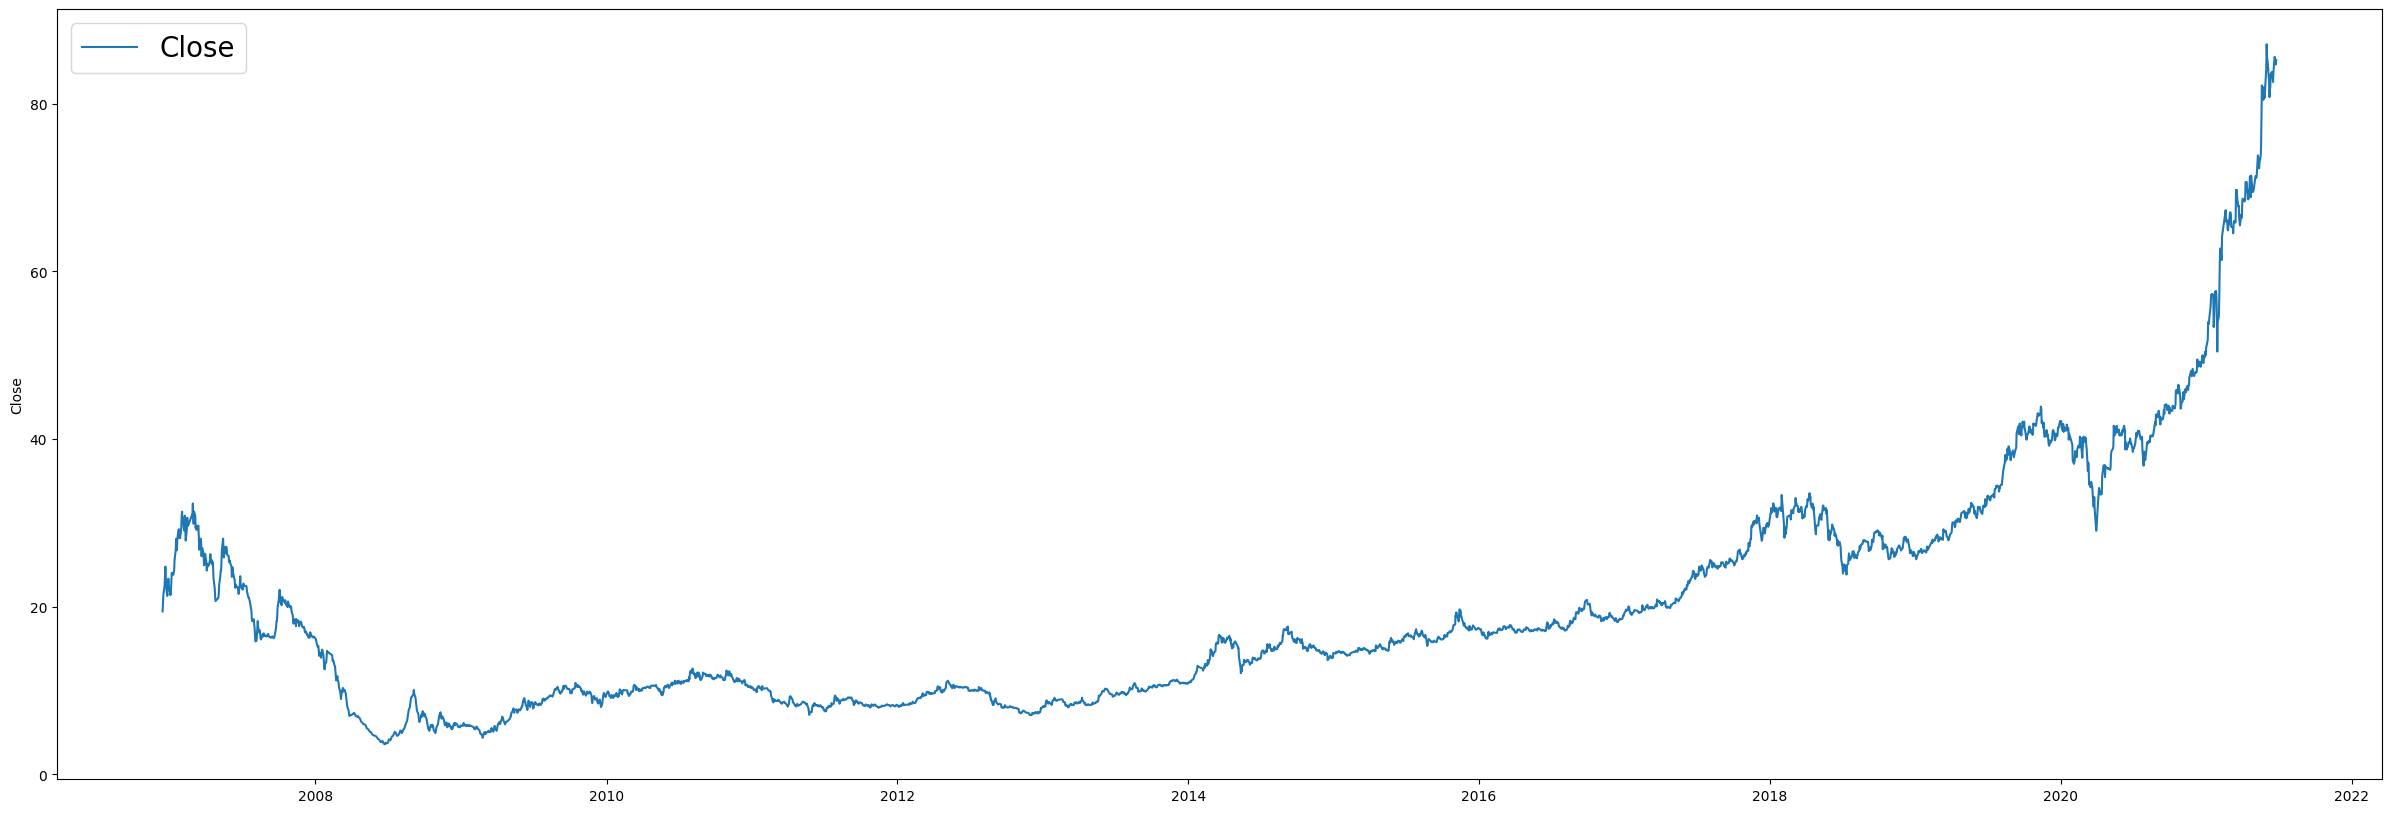

               Open     High      Low    Close
Date                                          
2006-12-13  19.4343  19.4343  19.4343  19.4343
2006-12-14  20.4060  20.4060  20.4060  20.4060
2006-12-15  21.4263  21.4263  21.4263  21.4263
2006-12-18  22.4952  22.4952  22.4952  22.4952
2006-12-19  23.6127  23.6127  23.6127  23.6127
...             ...      ...      ...      ...
2021-06-21  85.6000  86.3000  83.2000  85.6000
2021-06-22  86.1000  86.6000  85.4000  85.4000
2021-06-23  85.3000  85.6000  84.1000  84.9000
2021-06-24  84.3000  84.9000  83.9000  84.7000
2021-06-25  84.7000  85.4000  84.2000  85.2000

[3618 rows x 4 columns]


In [11]:
plt.figure(figsize=(30, 10))
plt.ylabel('Close')
plt.plot(training_set['Close'])
plt.legend(['Close'], loc ="upper left", fontsize='20')
plt.show()
print(training_set)

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


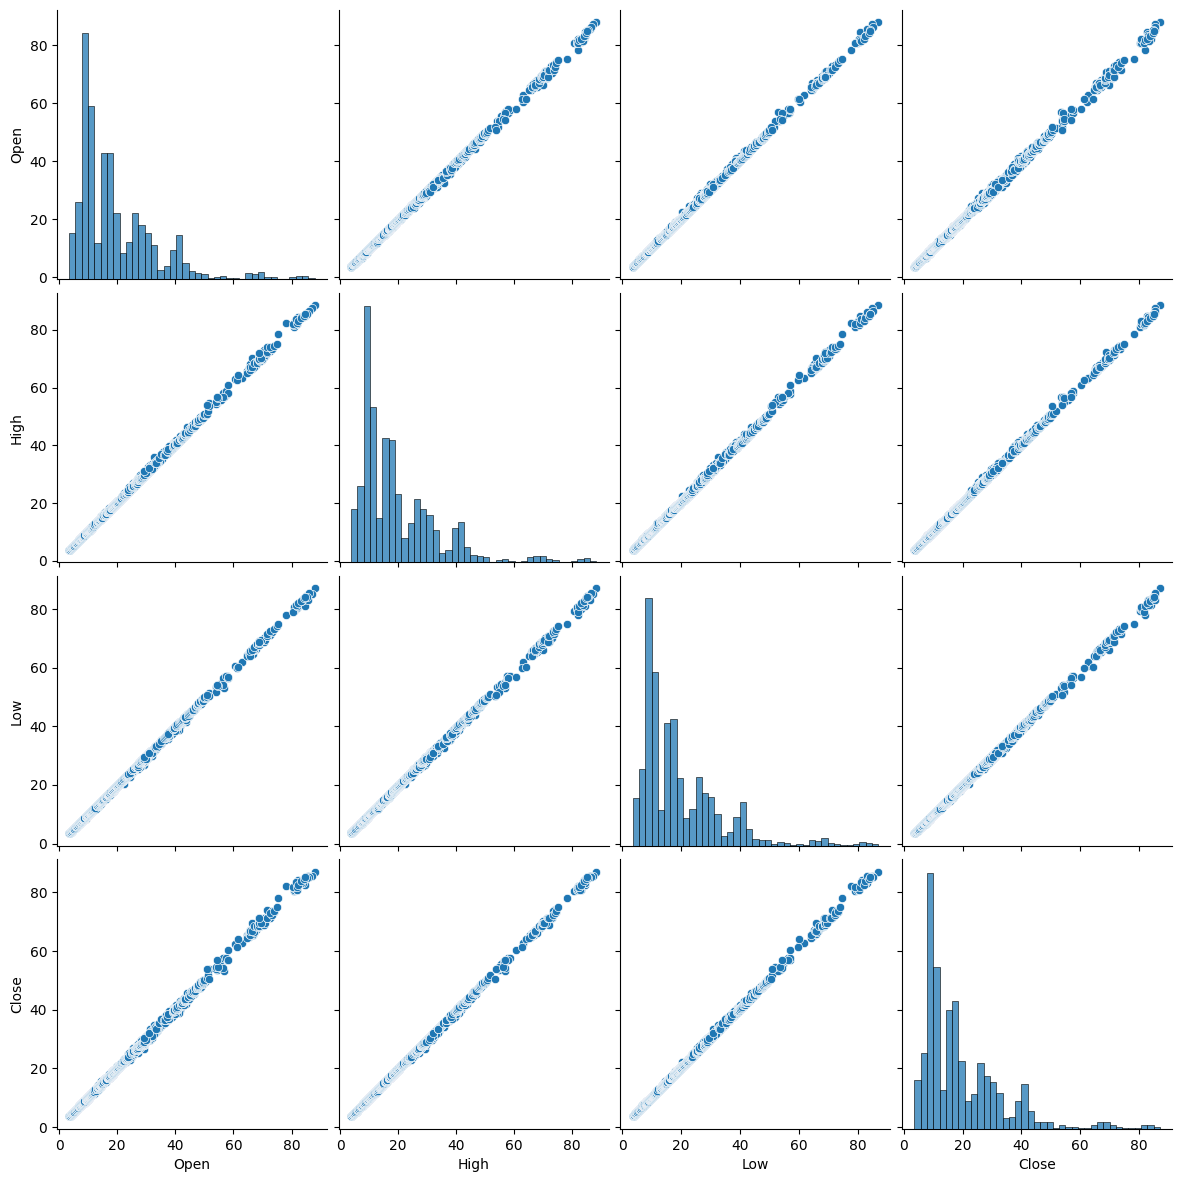

In [12]:
sns.pairplot(training_set, height=3)

<Axes: >

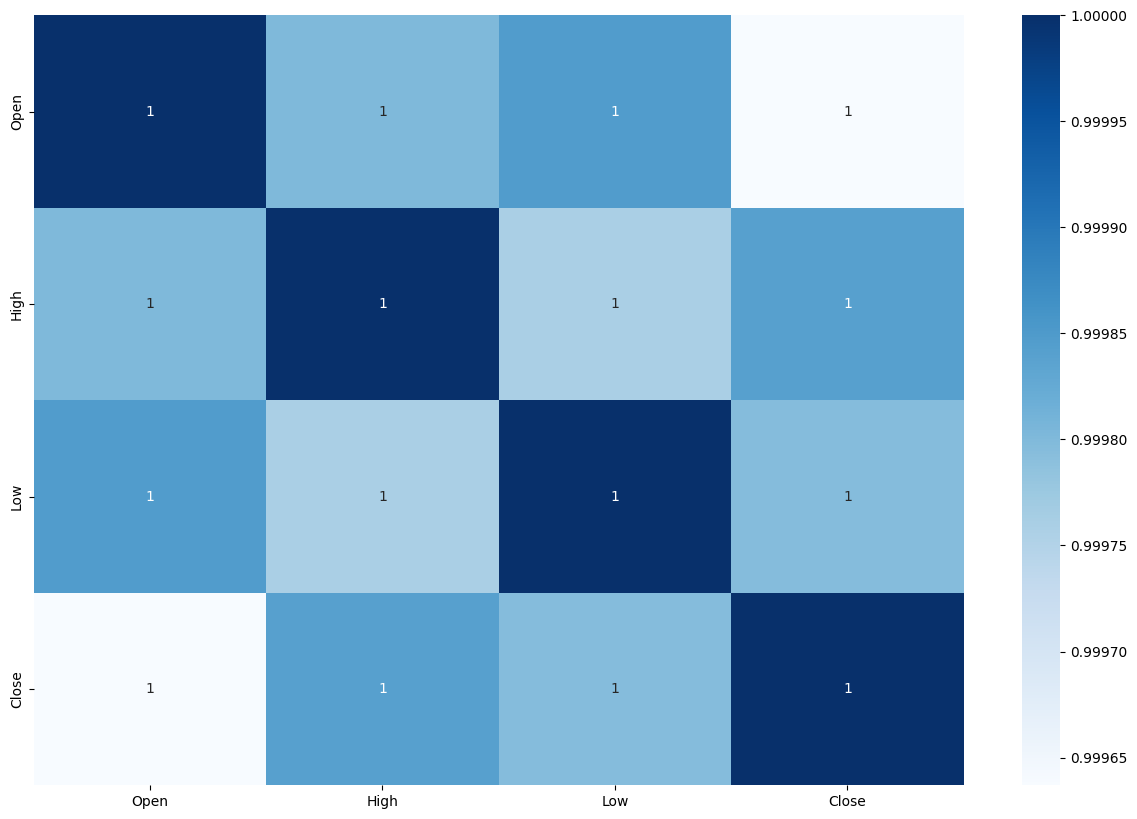

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(training_set.corr(), cmap='Blues', annot=True)

As shown on graphs above, variables have very high correlation to one another. Read more about how this affect models following this link [αlphαrithms](https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/#:~:text=Aside%3A%20Linear%20Regression,great%20options%20here.).

In [ ]:
# Add technical indicator EMA_10
training_set_processed = training_set.drop(['Open', 'High', 'Low'], axis=1)
training_set_processed.ta.ema(close='Close', length=10, append=True)
print(training_set_processed.head(20))

# Because EMA_10 is generated using results of 9 previous days, so the first 9 days in this dataset will have NaN values of EMA_10
training_set_processed.dropna(inplace=True)
print(training_set_processed.head(20))

              Close     EMA_10
Date                          
2006-12-13  19.4343        NaN
2006-12-14  20.4060        NaN
2006-12-15  21.4263        NaN
2006-12-18  22.4952        NaN
2006-12-19  23.6127        NaN
2006-12-20  24.7787        NaN
2006-12-21  23.5641        NaN
2006-12-22  22.3980        NaN
2006-12-25  21.2806        NaN
2006-12-26  22.3009  22.169680
2006-12-27  23.3212  22.379047
2006-12-28  23.3212  22.550348
2006-12-29  22.3494  22.513812
2007-01-02  21.3777  22.307246
2007-01-03  21.8636  22.226583
2007-01-04  22.9325  22.354932
2007-01-05  24.0499  22.663108
2007-01-08  23.8070  22.871088
2007-01-09  23.8070  23.041254
2007-01-10  24.0499  23.224644
              Close     EMA_10
Date                          
2006-12-26  22.3009  22.169680
2006-12-27  23.3212  22.379047
2006-12-28  23.3212  22.550348
2006-12-29  22.3494  22.513812
2007-01-02  21.3777  22.307246
2007-01-03  21.8636  22.226583
2007-01-04  22.9325  22.354932
2007-01-05  24.0499  22.663108
2007-01-

In [ ]:
# Add technical indicator EMA_10
test_set_processed = test_set.drop(['Open', 'High', 'Low'], axis=1)
test_set_processed.ta.ema(close='Close', length=10, append=True)
print(training_set_processed.head(20))

# Because EMA_10 is generated using results of 9 previous days, so the first 9 days in this dataset will have NaN values of EMA_10
test_set_processed.dropna(inplace=True)
print(test_set_processed.head(20))

              Close     EMA_10
Date                          
2006-12-26  22.3009  22.169680
2006-12-27  23.3212  22.379047
2006-12-28  23.3212  22.550348
2006-12-29  22.3494  22.513812
2007-01-02  21.3777  22.307246
2007-01-03  21.8636  22.226583
2007-01-04  22.9325  22.354932
2007-01-05  24.0499  22.663108
2007-01-08  23.8070  22.871088
2007-01-09  23.8070  23.041254
2007-01-10  24.0499  23.224644
2007-01-11  24.2929  23.418872
2007-01-12  25.5075  23.798623
2007-01-15  26.7707  24.339001
2007-01-16  28.0826  25.019655
2007-01-17  26.7222  25.329209
2007-01-18  26.7707  25.591298
2007-01-19  28.0826  26.044262
2007-01-22  29.1514  26.609196
2007-01-23  29.2486  27.089088
            Close     EMA_10
Date                        
2021-07-09   89.7  89.280000
2021-07-12   86.1  88.701818
2021-07-13   87.0  88.392397
2021-07-14   85.2  87.811961
2021-07-15   85.4  87.373423
2021-07-16   86.8  87.269164
2021-07-19   84.7  86.802043
2021-07-20   86.8  86.801672
2021-07-21   86.6  86.765004

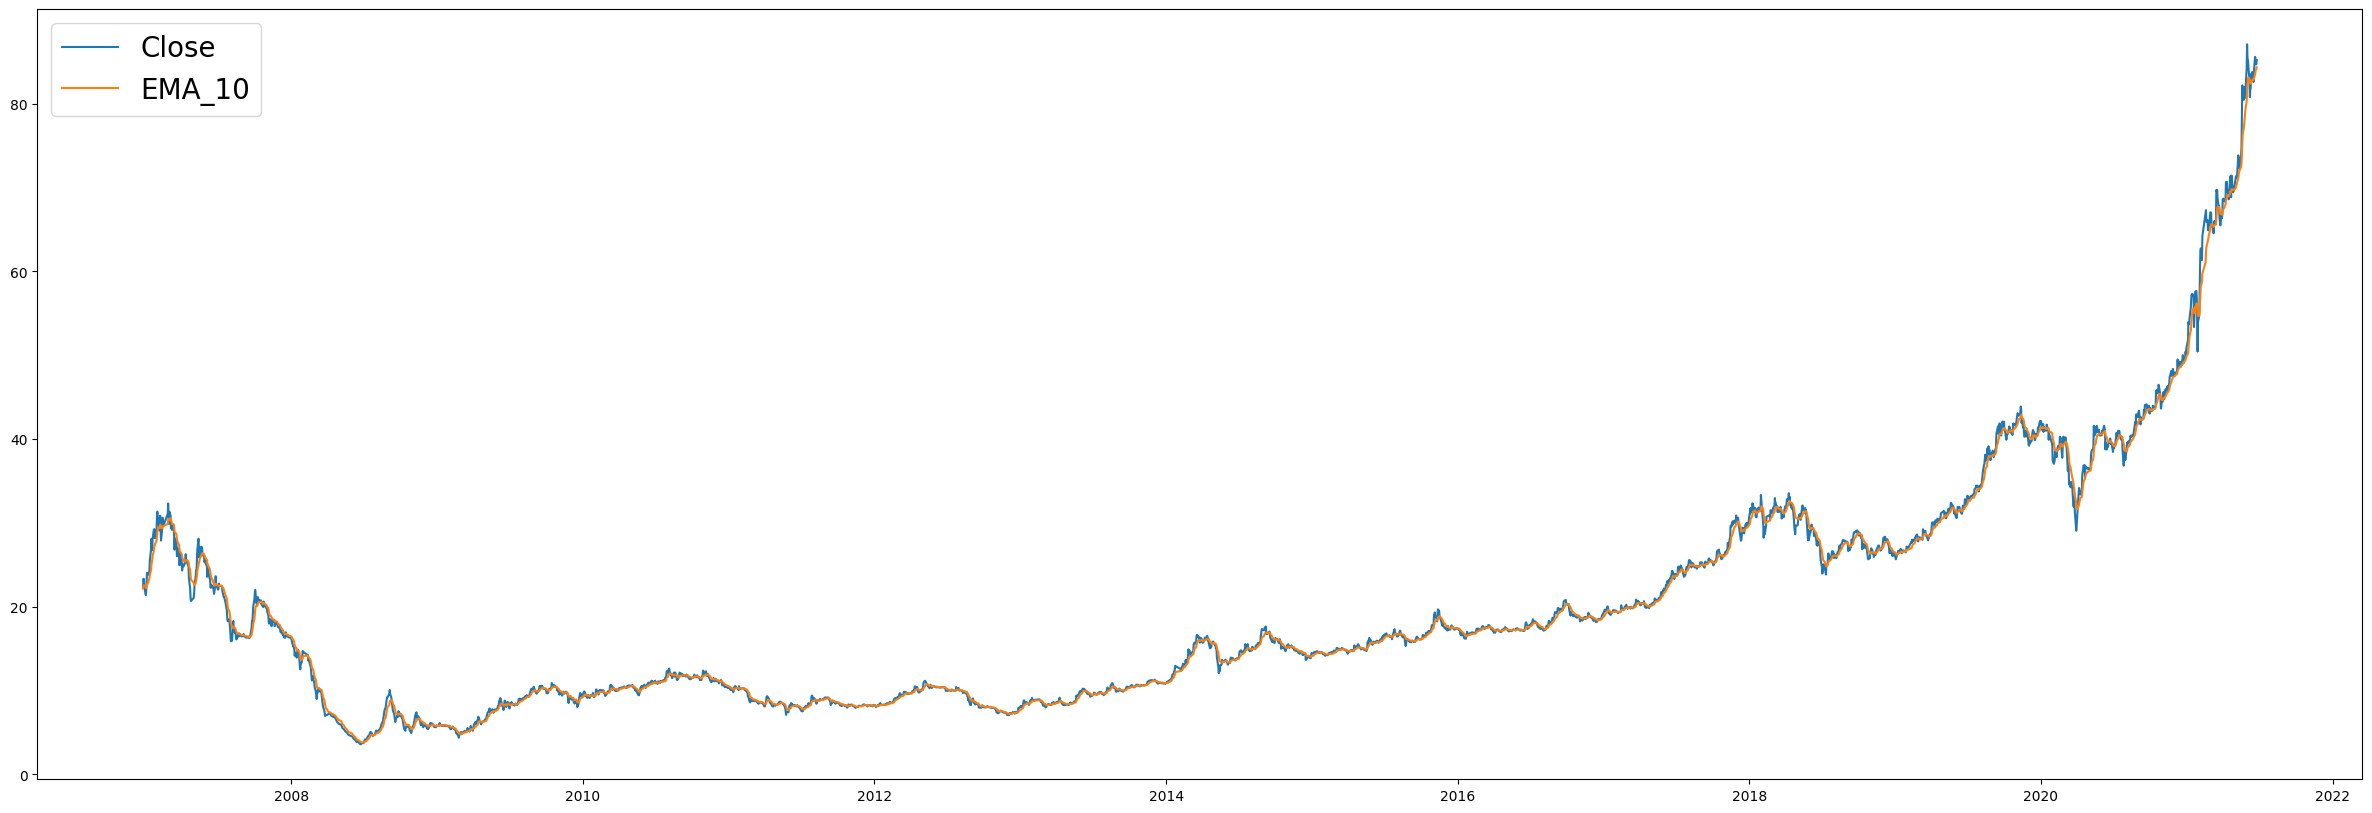

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(training_set_processed)
plt.legend(['Close', 'EMA_10'], loc ="upper left", fontsize='20')
plt.show()

In [ ]:
scaler = StandardScaler()
X_training, y_training = scaler.fit_transform(training_set_processed[['Close']]), training_set_processed['EMA_10']
X_test, y_test = scaler.transform(test_set_processed[['Close']]), test_set_processed['EMA_10']

print(X_training)


[[0.18639318]
 [0.25929183]
 [0.25929183]
 ...
 [4.6589893 ]
 [4.64469965]
 [4.68042377]]


# Try 2 - using Open and predict Close

[[-0.01882337]
 [ 0.05082161]
 [ 0.12394991]
 ...
 [ 4.70199078]
 [ 4.63031745]
 [ 4.65898678]]                Open
Date               
2006-12-13  19.4343
2006-12-14  20.4060
2006-12-15  21.4263
2006-12-18  22.4952
2006-12-19  23.6127
...             ...
2021-06-21  85.6000
2021-06-22  86.1000
2021-06-23  85.3000
2021-06-24  84.3000
2021-06-25  84.7000

[3618 rows x 1 columns]


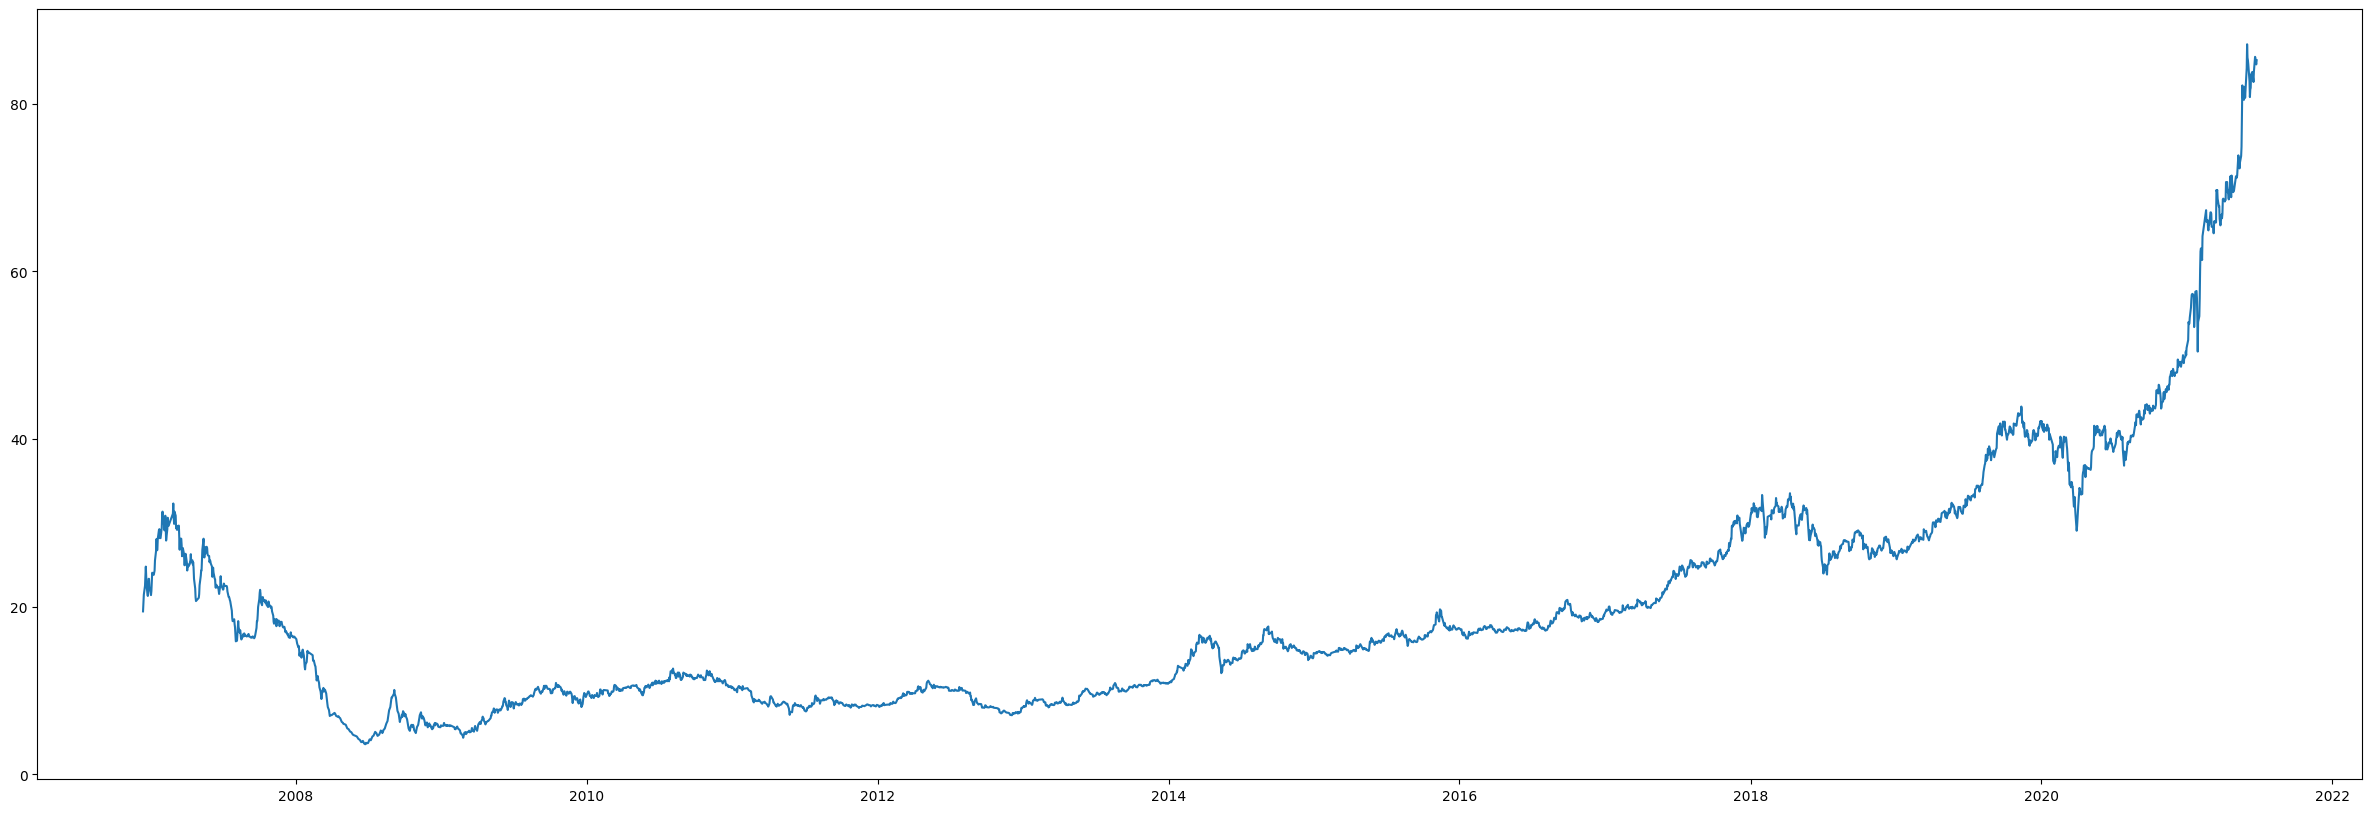

In [ ]:
scaler = StandardScaler()
X_training, y_training = scaler.fit_transform(training_set[['Open']]), training_set['Close']
X_test, y_test = scaler.transform(test_set[['Open']]), test_set['Close']

print(X_training, training_set[['Open']])

plt.figure(figsize=(30, 10))
plt.plot(y_training)

# Ordinary Least Squares

*References:*

* [Scikit-learn (2022). Linear Regression.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [ ]:
ols = LinearRegression()
ols.fit(X_training, y_training)
print('Coefficients:', ols.coef_, sep='\n')
print('Intercept:', ols.intercept_, sep='\n')

Coefficients:
[13.9744146]
Intercept:
19.698241072415698


# Ridge Regression

*References:*

* [Scikit-learn (2022). Ridge Regression.](https://)

In [ ]:
ridge = Ridge()
print('Ridge parameters:', ridge.get_params(), sep='\n')

Ridge parameters:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [ ]:
ridge_hyperparams = {
    'alpha': numpy.arange(0.1, 10.1, 0.1).tolist()
}

ridge_search = GridSearchCV(
    ridge,
    ridge_hyperparams,
    cv=10
)

ridge_search.fit(X_training, y_training)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                                   0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                                   1.2000000000000002, 1.3000000000000003,
                                   1.4000000000000001, 1.5000000000000002, 1.6,
                                   1.7000000000000002, 1.8000000000000003,
                                   1.9000000000000001, 2.0, 2.1, 2.2,
                                   2.3000000000000003, 2.4000000000000004,
                                   2.5000000000000004, 2.6, 2.7,
                                   2.8000000000000003, 2.9000000000000004,
                                   3.0000000000000004, ...]})

In [ ]:
ridge = ridge_search.best_estimator_
ridge.get_params()

{'alpha': 1.9000000000000001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

# Lasso Regression

References:
* [Scikit-learn (2022). Lasso Regression.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)



In [ ]:
lasso = Lasso()
print('Lasso parameters:', lasso.get_params(), sep='\n')

Lasso parameters:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [ ]:
lasso_hyperparams = {
    'alpha': numpy.arange(0.1, 10.1, 0.1).tolist()
}

lasso_search = GridSearchCV(
    lasso,
    lasso_hyperparams,
    cv=10
)

lasso_search.fit(X_training, y_training)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                                   0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                                   1.2000000000000002, 1.3000000000000003,
                                   1.4000000000000001, 1.5000000000000002, 1.6,
                                   1.7000000000000002, 1.8000000000000003,
                                   1.9000000000000001, 2.0, 2.1, 2.2,
                                   2.3000000000000003, 2.4000000000000004,
                                   2.5000000000000004, 2.6, 2.7,
                                   2.8000000000000003, 2.9000000000000004,
                                   3.0000000000000004, ...]})

In [ ]:
lasso = lasso_search.best_estimator_
lasso.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

# Random Forest

*References:*
* [Scikit-learn (2022). RandomForestRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* [Jason Brownlee (2020). How to Develop a Random Forest Ensemble in Python.](https://machinelearningmastery.com/random-forest-ensemble-in-python/)
* [Will Koehrsen (2018). Hyperparameter Tuning the Random Forest in Python.](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [ ]:
# random forest with default hyperparameters init by scikit-learn
rf = RandomForestRegressor()
params = {
    'bootstrap': True,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 1000,
}
rf.set_params(**params)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
"""
+ Search over space of hyperparameters to find acceptable ones
+ Two search methods implemented by scikit-learn: GridSearch and RandomSearch
+ RandomSearch is faster in case we search over large space (too many combinations of hyperparameters)
"""

rf_hyperparams = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [None, 10, 50, 90, 110],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_randomized_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = rf_hyperparams,
    n_iter = 10,
    cv = 5,
    verbose=2,
    random_state=42,
    n_jobs = -1
)
X_training, y_training = training_set[['Open']], training_set['Close']
#rf_randomized_search.fit(X_training, y_training)
rf.fit(X_training, y_training)

RandomForestRegressor(max_depth=5, max_features='auto', min_samples_leaf=4)

In [ ]:
# rf = rf_randomized_search.best_estimator_
# rf.get_params()

# Predictions & Scores

In [ ]:
def validate_date_str(date_str):
  try:
    datetime.datetime.strptime(date_str, '%Y-%m-%d')
  except ValueError:
    raise ValueError("Incorrect data format, should be YYYY-MM-DD")

def get_estimator_scores(estimator, y_truth, X):
  return {
      'MAE': mean_absolute_error(y_truth, estimator.predict(X)),
      'MSE': mean_squared_error(y_truth, estimator.predict(X)),
      'R-squared': r2_score(y_truth, estimator.predict(X))
  }

def plot_prediction(estimator, date_index, X, y_truth, plot_type='mix', lower_bound=None, upper_bound=None, plot_title=None):
  y_truth_ndarray = y_truth.values
  y_pred_ndarray = estimator.predict(X)

  if type(lower_bound) != type(upper_bound):
    raise Exception('Lower and upper bound must share the same data type.')

  if lower_bound and upper_bound:
    if isinstance(lower_bound, str) and isinstance(upper_bound, str):
      validate_date_str(lower_bound)
      validate_date_str(upper_bound)
      lower_bound = date_index.get_loc(lower_bound)
      upper_bound = date_index.get_loc(upper_bound)

    date_index = date_index[lower_bound:upper_bound]
    y_truth_ndarray = y_truth_ndarray[lower_bound:upper_bound]
    y_pred_ndarray = y_pred_ndarray[lower_bound:upper_bound]

  plt.figure(figsize=(30, 10))
  if plot_title:
    plt.title(plot_title, fontsize=20)

  if plot_type == 'mix':
    plt.plot(date_index, y_truth_ndarray, '-r', date_index, y_pred_ndarray, 'xb')
  if plot_type == 'scatter':
    plt.scatter(x=date_index, y=y_truth_ndarray, color='red')
    plt.scatter(x=date_index, y=y_pred_ndarray, color='blue')

  plt.legend(['Ground Truth', 'Predicted Value'], loc ="upper left", fontsize='20')
  plt.show()

In [ ]:
models_scores_on_training_set = pd.DataFrame(
    data=[
        get_estimator_scores(ols, y_training, X_training),
        get_estimator_scores(ridge, y_training, X_training),
        get_estimator_scores(lasso, y_training, X_training),
        get_estimator_scores(rf, y_training, X_training)
    ],
    index=['OLS', 'Ridge', 'Lasso', 'Random Forest']
)
models_scores_on_training_set.style.set_caption('Models \'s Scores On Training Set').set_table_styles([
    dict(selector='caption', props=[('font-size', '120%'), ('font-weight', 'bold'), ('margin-bottom', '20px')])
])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packag

,MAE,MSE,R-squared
OLS,275.253028,108525.112240,-554.325447
Ridge,275.108554,108408.563998,-553.729067
Lasso,273.283335,106941.543482,-546.222290
Random Forest,0.311796,0.204746,0.998952


In [ ]:
models_scores_on_test_set = pd.DataFrame(
    data=[
        get_estimator_scores(ols, y_test, X_test),
        get_estimator_scores(ridge, y_test, X_test),
        get_estimator_scores(lasso, y_test, X_test),
        get_estimator_scores(rf, y_test, X_test)
    ],
    index=['OLS', 'Ridge', 'Lasso', 'Random Forest']
)
models_scores_on_test_set.style.set_caption('Models \'s Scores On Test Set').set_table_styles([
    dict(selector='caption', props=[('font-size', '120%'), ('font-weight', 'bold'), ('margin-bottom', '20px')])
])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,MAE,MSE,R-squared
OLS,1.195088,3.024062,0.970616
Ridge,1.189565,3.013523,0.970718
Lasso,1.219289,3.123547,0.969649
Random Forest,85.241427,7358.408851,-70.499925


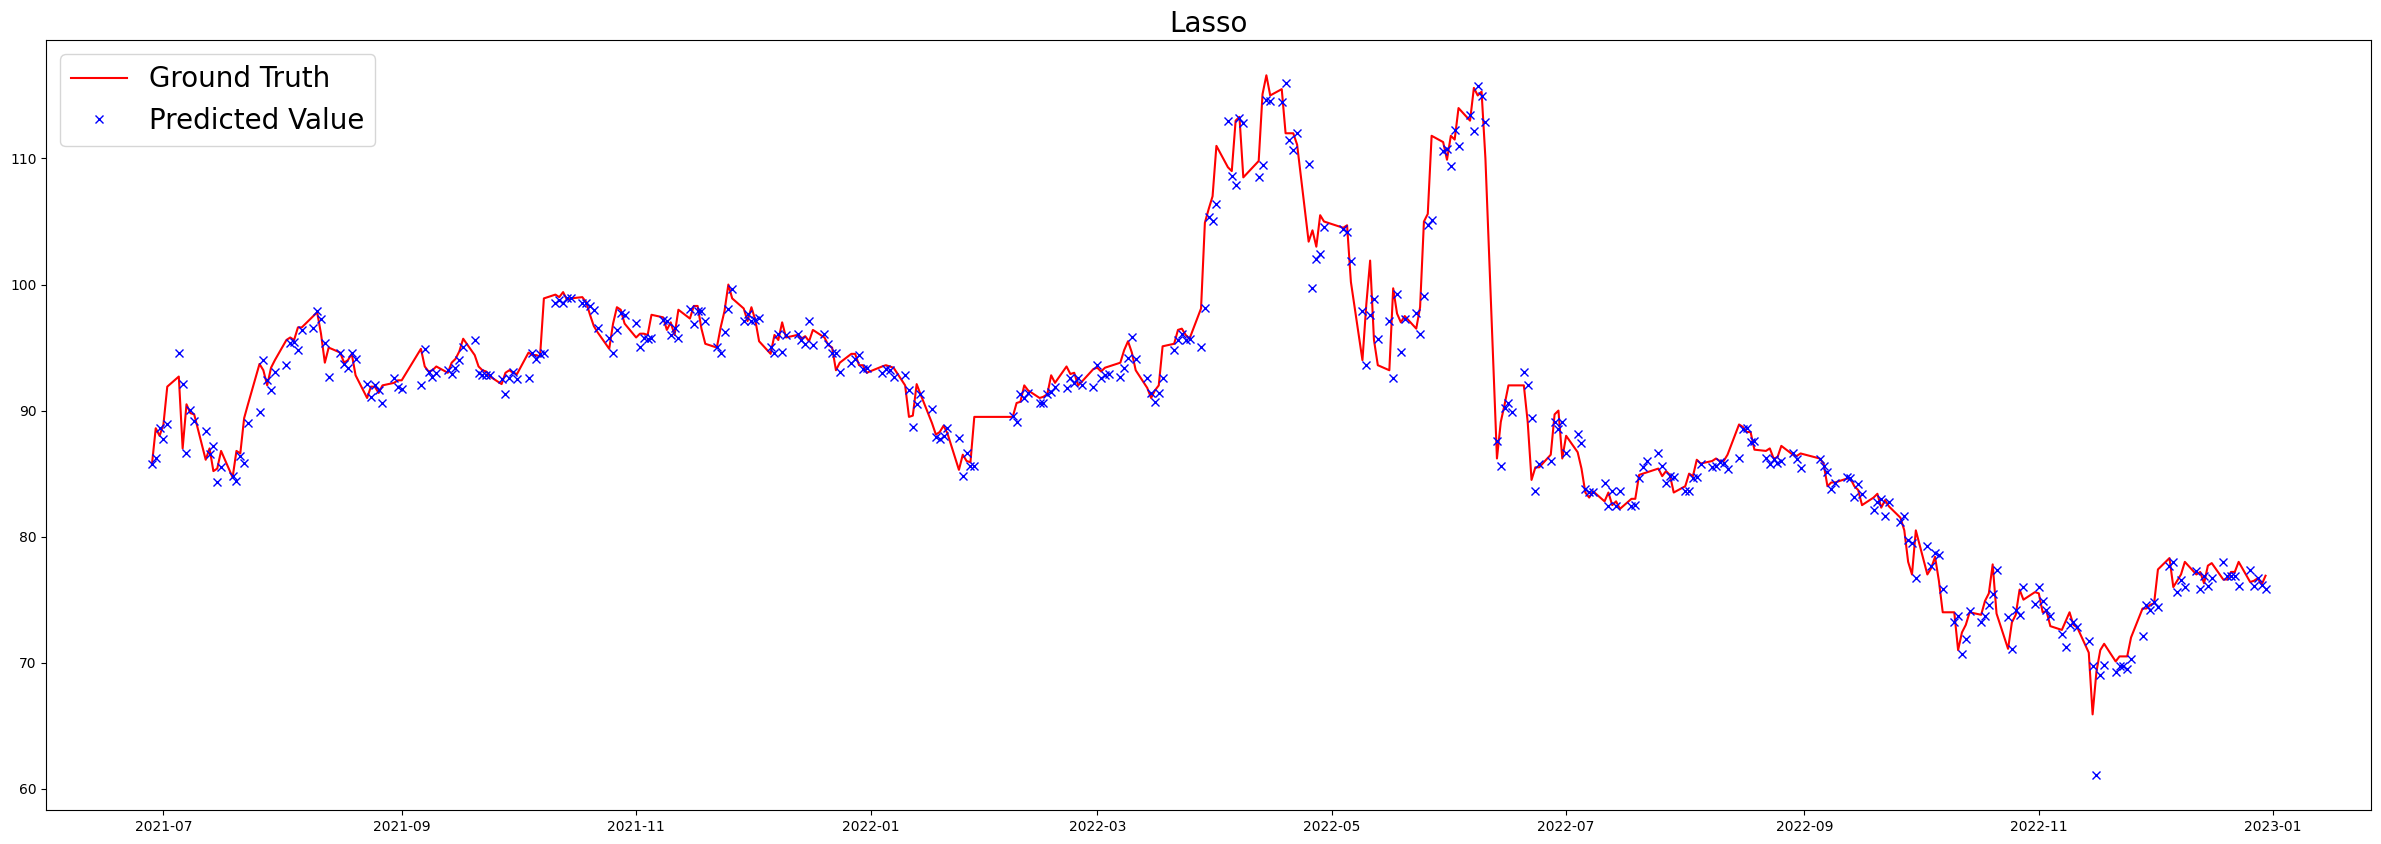

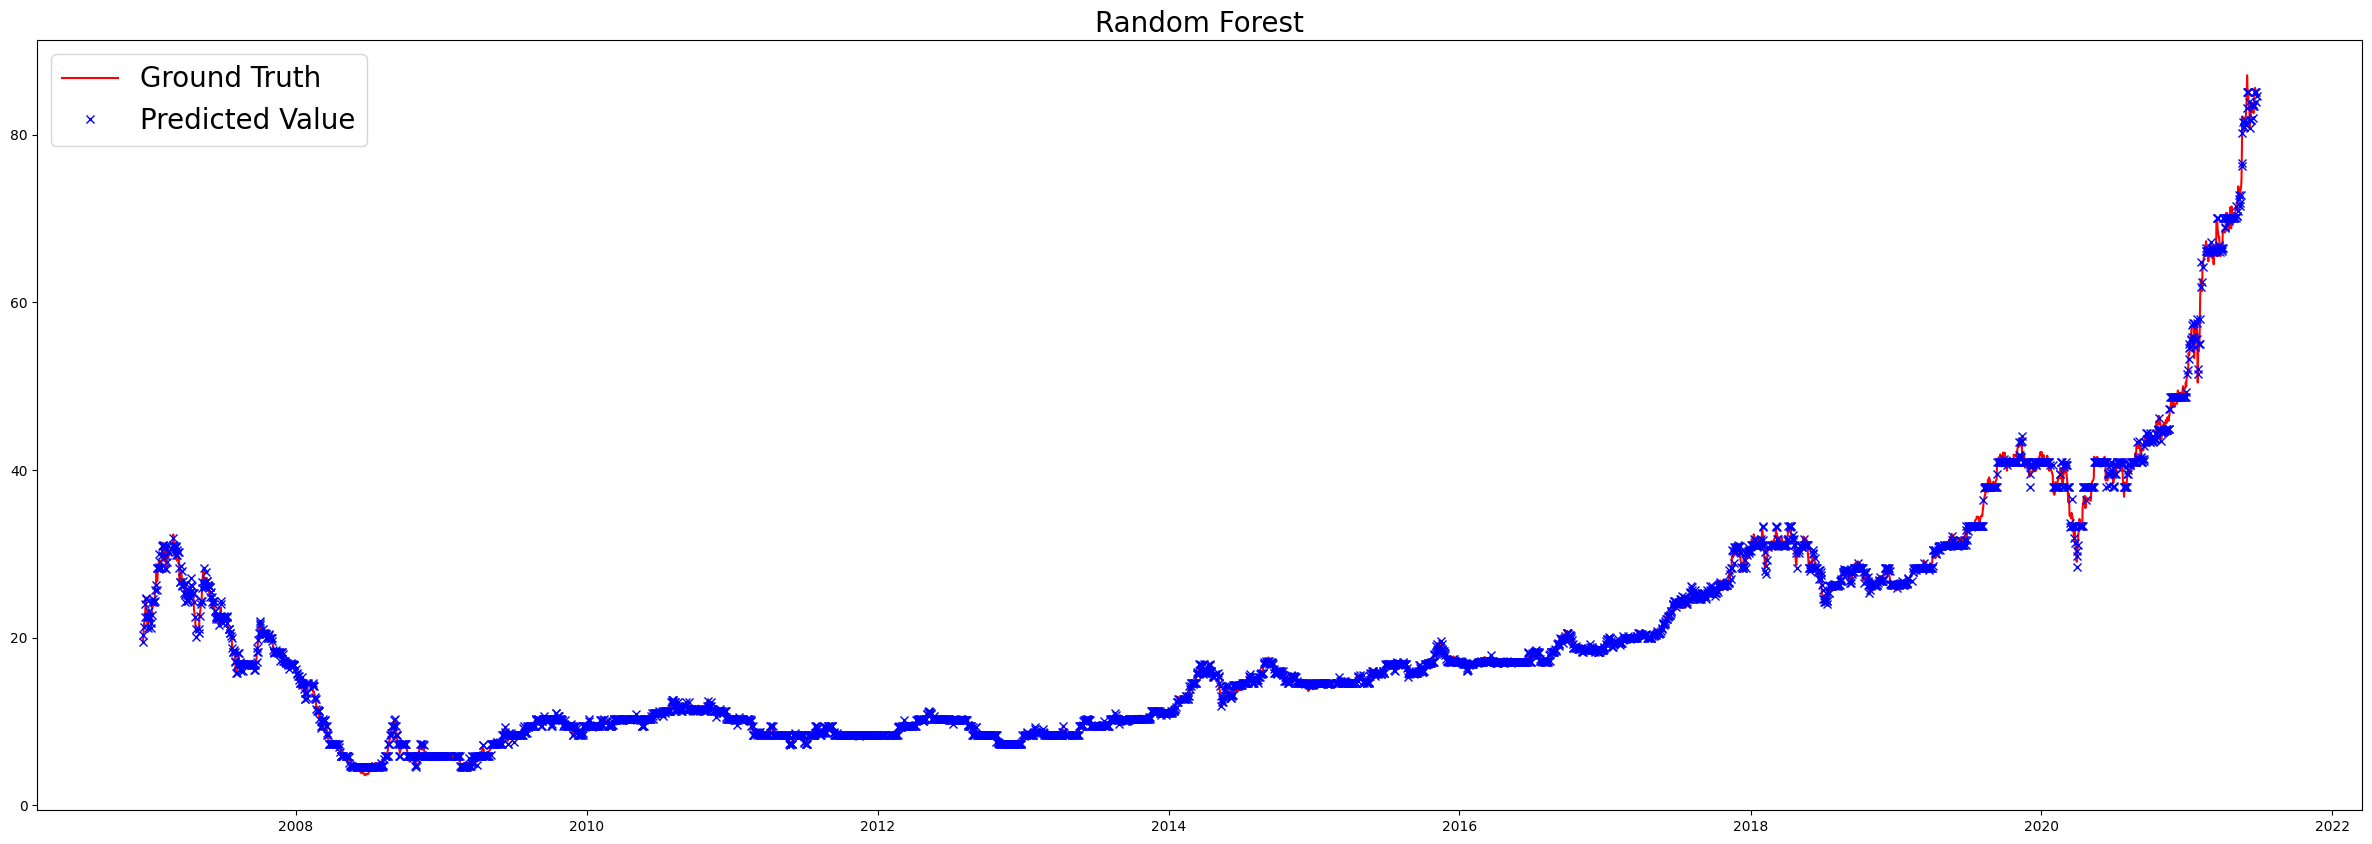

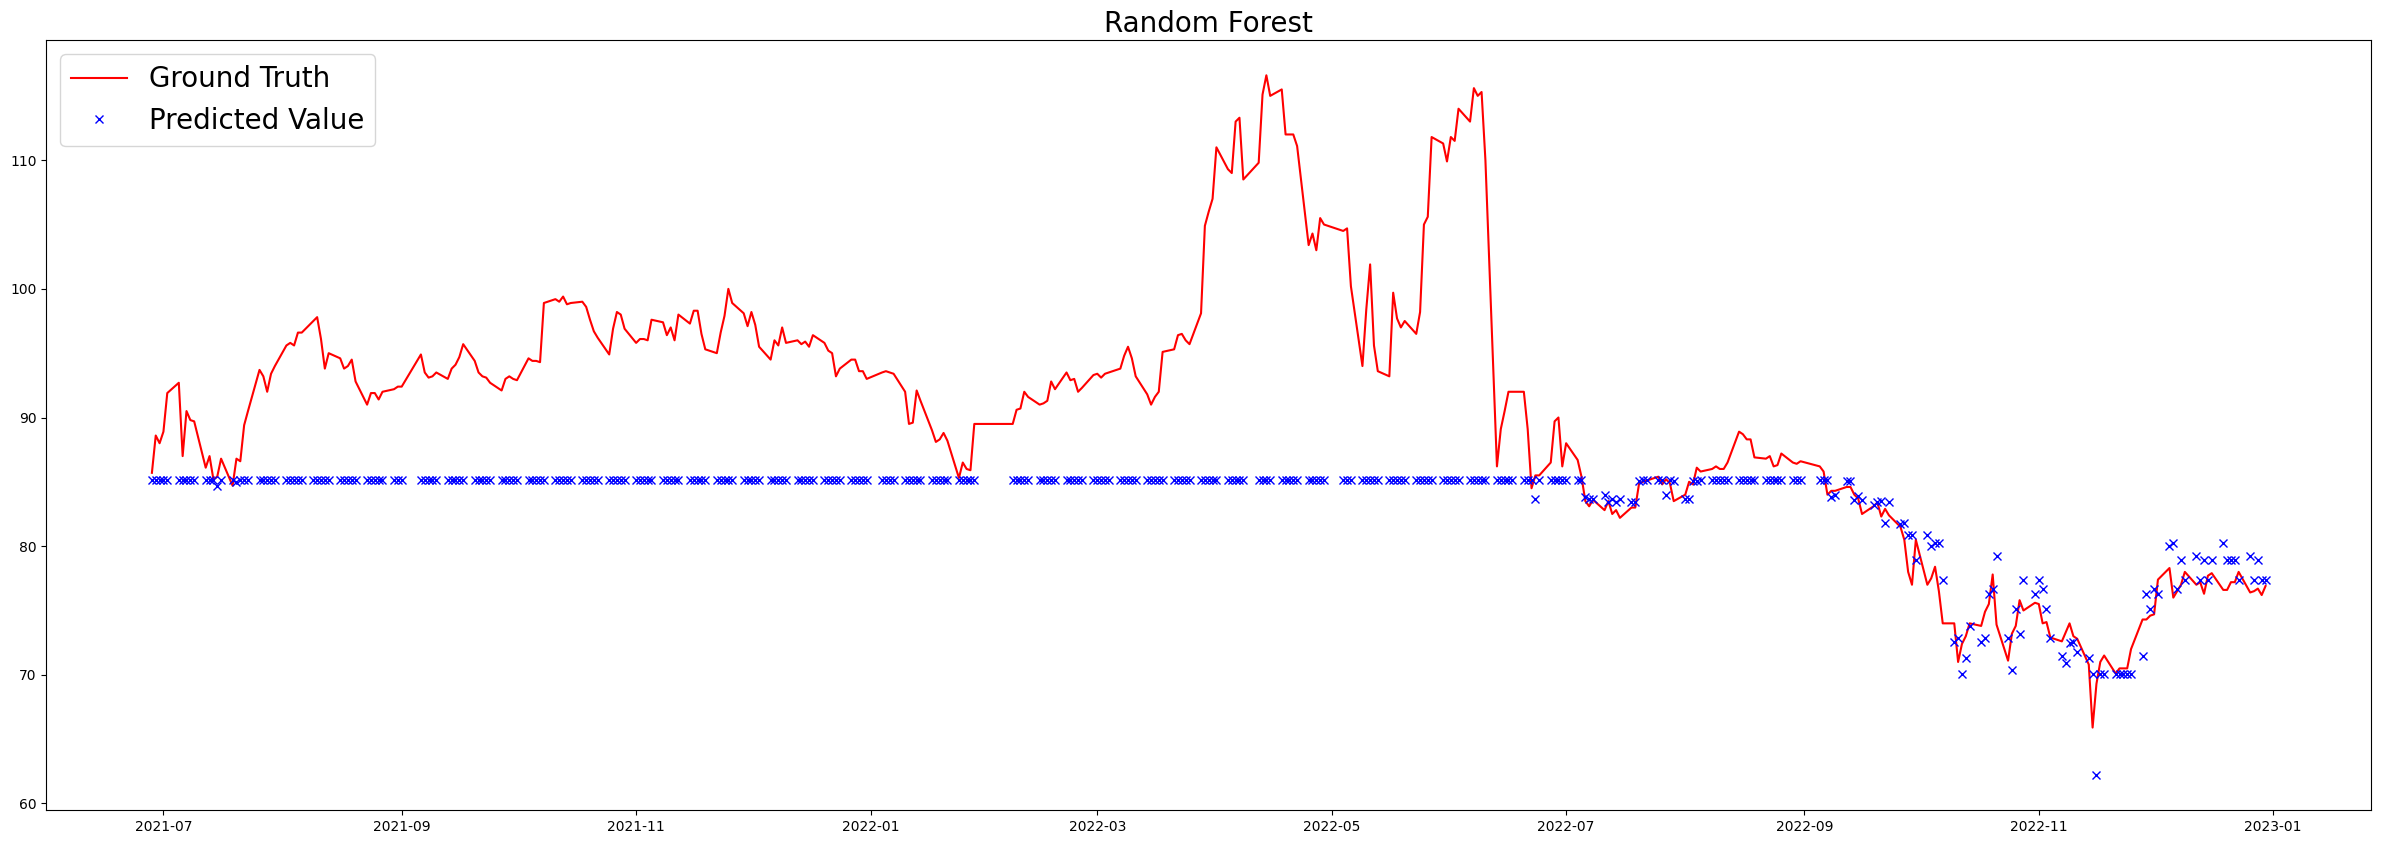

In [ ]:
# plot_prediction(ols, test_set.index, X_test, y_test, plot_title='Ordinary Least Square')
# plot_prediction(ridge, test_set.index, X_test, y_test, plot_title='Ridge')
plot_prediction(lasso, test_set.index, X_test, y_test, plot_title='Lasso')
plot_prediction(rf, training_set.index, X_training, y_training, plot_title='Random Forest')
X_test, y_test = test_set[['Open']], test_set['Close']
plot_prediction(rf, test_set.index, X_test, y_test, plot_title='Random Forest')